## Imports

In [53]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression

## Data Extraction

In [54]:
train_data = pd.read_csv('./archive/Train.csv')
test_data = pd.read_csv('./archive/Test.csv')
validation_data = pd.read_csv('./archive/Valid.csv')
train_data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [55]:
x_tr, y_tr = train_data['text'].values, train_data['label'].values
x_val, y_val = validation_data['text'].values, validation_data['label'].values


In [56]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=10000)
word_to_ix = vectorizer.fit(train_data.text)

In [69]:
VOCAB_SIZE = len(word_to_ix.vocabulary_)
NUM_LABELS = 2

tr_data_vecs = torch.FloatTensor(word_to_ix.transform(x_tr).toarray())
tr_labels = y_tr.tolist()

val_data_vecs = torch.FloatTensor(word_to_ix.transform(x_val).toarray())
val_labels = y_val.tolist()

tr_data_loader = [(sample, label) for sample, label in zip(tr_data_vecs, tr_labels)]
val_data_loader = [(sample, label) for sample, label in zip(val_data_vecs, val_labels)]


In [70]:
BATCH_SIZE = 64

from torch.utils.data import DataLoader

train_iterator = DataLoader(tr_data_loader,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            )

valid_iterator = DataLoader(val_data_loader,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          )

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [72]:
from torch import nn

class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
      
        super(BoWClassifier, self).__init__()

        self.linear = nn.Linear(vocab_size, num_labels)

    def forward(self, bow_vec):
       
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [73]:

INPUT_DIM = VOCAB_SIZE

OUTPUT_DIM = 2

model = BoWClassifier(OUTPUT_DIM, INPUT_DIM)

In [74]:

import torch.optim as optim


optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [87]:
from collections import defaultdict

criterion = nn.NLLLoss()

model = model.to(device)
criterion = criterion.to(device)
metrics = defaultdict(list)

In [76]:
from sklearn.metrics import classification_report
def class_accuracy(preds, y):
   
    rounded_preds = preds.argmax(1)
    
    correct = (rounded_preds == y).float()
    
 
    acc = correct.sum() / len(correct)
    return acc

In [97]:
import torch.nn.functional as F


def train(model, iterator, optimizer, criterion):
    
    
    epoch_loss = 0
    epoch_acc = 0
    
    
    model.train()
    
    for texts, labels in iterator:
     
        texts = texts.to(device)
        labels = labels.to(device)
        
       
        optimizer.zero_grad()
                
    
        predictions = model(texts)

       
        loss = criterion(predictions, labels)
        
        acc = class_accuracy(predictions, labels)
        
       
        loss.backward()
        optimizer.step()
        
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [98]:

# The evaluation is done on the validation dataset
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # On the validation dataset we don't want training so we need to set the model on evaluation mode
    model.eval()
    
    # Also tell Pytorch to not propagate any error backwards in the model
    # This is needed when you only want to make predictions and use your model in inference mode!
    with torch.no_grad():
    
        # The remaining part is the same with the difference of not using the optimizer to backpropagation
        for texts, labels in iterator:
            # We copy the text and label to the correct device
            texts = texts.to(device)
            labels = labels.to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
           
            
            acc = class_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [99]:
import time

# This is just for measuring training time!
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [102]:
# Define the epoch number parameter
N_EPOCHS = 50

best_valid_loss = float('inf')

# We loop forward on the epoch number
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    # Train the model on the training set using the dataloader
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    metrics['train_loss'].append(train_loss)
    metrics['train_accuracy'].append(train_acc)
    # And validate your model on the validation set
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    metrics['dev_loss'].append(valid_loss)
    metrics['dev_accuracy'].append(valid_acc)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # If we find a better model, we save the weights so later we may want to reload it
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.016 | Train Acc: 99.89%
	 Val. Loss: 1.357 |  Val. Acc: 84.93%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.016 | Train Acc: 99.89%
	 Val. Loss: 1.369 |  Val. Acc: 84.95%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.016 | Train Acc: 99.90%
	 Val. Loss: 1.367 |  Val. Acc: 84.95%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.016 | Train Acc: 99.89%
	 Val. Loss: 1.374 |  Val. Acc: 84.83%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.015 | Train Acc: 99.89%
	 Val. Loss: 1.379 |  Val. Acc: 84.91%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.015 | Train Acc: 99.89%
	 Val. Loss: 1.382 |  Val. Acc: 84.97%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.015 | Train Acc: 99.90%
	 Val. Loss: 1.386 |  Val. Acc: 84.85%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.015 | Train Acc: 99.90%
	 Val. Loss: 1.393 |  Val. Acc: 84.89%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.015 | Train Acc: 99.91%
	 Val. Loss: 1.405 |  Val. Acc: 84.87%
Epoch: 10 | Epoch Time: 0m 1

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

TypeError: len() of a 0-d tensor

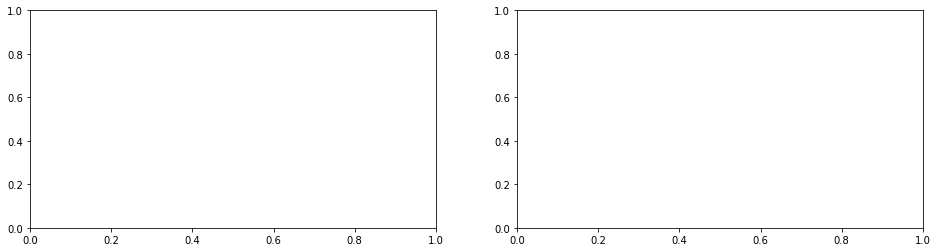

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.lineplot(data=metrics['train_loss'], ax=ax[0], label='train loss')
sns.lineplot(data=metrics['dev_loss'], ax=ax[0], label='dev loss')

sns.lineplot(data=metrics['train_accuracy'], ax=ax[1], label='train acc')
sns.lineplot(data=metrics['dev_accuracy'], ax=ax[1], label='dev acc')